# Regression

In [1]:
import jax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import dense_output, ivpsolve, solvers
from odefilter.strategies import smoothers

config.update("jax_enable_x64", True)

if not backend.has_been_selected:
    backend.select("jax")

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()
f_args = jnp.asarray(f_args)


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)

In [3]:
# make data

ts = jnp.linspace(t0, t1, endpoint=True, num=50)
ek0 = solvers.MLESolver(strategy=smoothers.FixedPointSmoother())

solution_true = ivpsolve.simulate_checkpoints(
    vf, initial_values=(u0,), ts=ts, solver=ek0, parameters=f_args + 0.05
)
data = solution_true.u

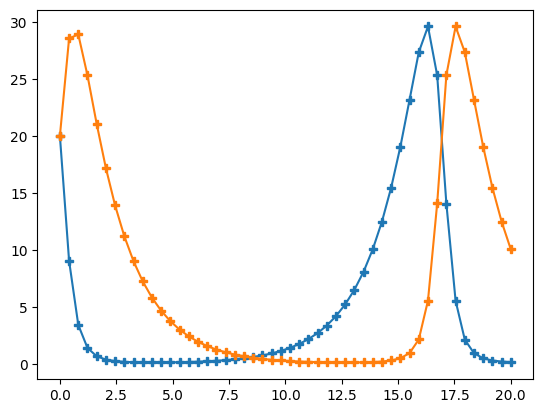

In [4]:
plt.plot(ts, data, "P-")
plt.show()

In [5]:
# Initial guess

solution_wrong = ivpsolve.simulate_checkpoints(
    vf, initial_values=(u0,), ts=ts, solver=ek0, parameters=f_args
)

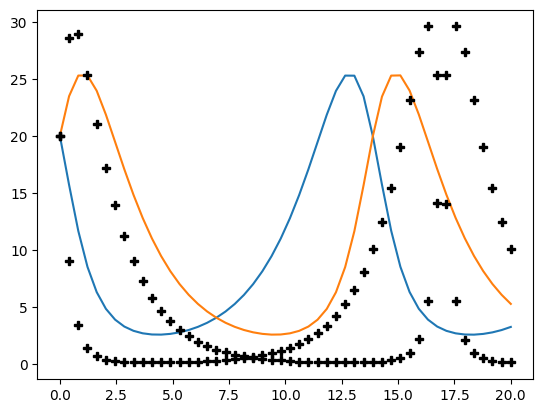

In [6]:
plt.plot(ts, solution_wrong.u, "-")
plt.plot(ts, data, "P", color="k")
plt.show()

In [7]:
@jax.jit
@jax.jacfwd
def param_to_nmll(p):
    observation_std = jnp.ones_like(ts) * 0.01
    solution_wrong = ivpsolve.simulate_checkpoints(
        vf, initial_values=(u0,), ts=ts, solver=ek0, parameters=p
    )
    return dense_output.negative_marginal_log_likelihood(
        observation_std=observation_std, u=data, solution=solution_wrong, solver=ek0
    )

In [8]:
%%time

param_to_nmll(f_args)

CPU times: user 10.4 s, sys: 53.9 ms, total: 10.4 s
Wall time: 10.2 s


DeviceArray([nan, nan, nan, nan], dtype=float64)

In [9]:
# Optimize with optax...